# Sample size calculation

Function to compute the sample size & some analyses to play around.

In [1]:
# Some imports, ignore this
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

*The* function to compute the sample size, this piece of code we should iterate: 

In [2]:
def sample_size_needed(sensitivity, prevalence, confidence_level, wilson_lower_limit, discard_rate):
    z = norm.ppf((1 + confidence_level) / 2)  # Z-value for the specified confidence level
    n = 10  # Very low initial guess for the number of total participants

    while True:
        n += 1 # Increase the sample size by 1
        effective_sample_size = int(n * (1 - discard_rate))  # Adjust sample size for expected discards
        # Compute the expected number of positive cases taking the prevalence into account
        expected_positives = int(effective_sample_size * prevalence) 
        
        if expected_positives == 0: 
            continue  # Skip if there are no expected positive cases 
        
        # Calculate the Wilson score interval for the expected number of positive cases
        interval = sm.stats.proportion_confint(int(expected_positives * sensitivity), 
                                               int(expected_positives), 
                                               alpha= 1-confidence_level, 
                                               method='wilson')
        
        # Check if the lower limit of the interval is greater than the desired lower limit
        if interval[0] > wilson_lower_limit:
            break

        if n > 50000: 
            raise ValueError("Sample size is too large. Please check your input values.")

    # Compute the expected number of useful positive cases
    useful_positives = int(n * prevalence * sensitivity)  
    return n, useful_positives


## Computing the sample size

Some parameters, taken from the analyzed documents:

In [3]:
desired_sensitivity = 0.97
prevalence = 0.10
desired_confidence_level = 0.95
wilson_ci_lower_limit = 0.90
discard_rate = 0.00

We call the function:

In [4]:
total_sample_size, useful_positive_cases = sample_size_needed(desired_sensitivity, 
                                                              prevalence, 
                                                              desired_confidence_level, 
                                                              wilson_ci_lower_limit, 
                                                              discard_rate)

In [5]:
# We print the results
print(f"Estimated minimum total sample size needed: {total_sample_size}")
print(f"Expected number of useful positive cases: {useful_positive_cases}")

Estimated minimum total sample size needed: 840
Expected number of useful positive cases: 81


As you can see, the obtained numbers are *around* the once you computed, but not the same ones.  

## Adding 10% discards

Same as before but considering discarded data

In [6]:
discard_rate = 0.10

In [7]:
total_sample_size, useful_positive_cases = sample_size_needed(desired_sensitivity, 
                                                              prevalence, 
                                                              desired_confidence_level, 
                                                              wilson_ci_lower_limit, 
                                                              discard_rate)

In [8]:
print(f"Estimated minimum total sample size needed: {total_sample_size}")
print(f"Expected number of useful positive cases: {useful_positive_cases}")

Estimated minimum total sample size needed: 934
Expected number of useful positive cases: 90


Again, similar numbers but not the same ones you computed. 

## Considering risks & benefits

In order to consider how the sample size changes depending on being applied before of after cell inspection (the mentioned 30%), the function is the same one, the only thing to change is the prevalence (i.e. 30% benefited with the dx of the 10% prevalence = 3% "final" prevalence). 

In [9]:
# Standard values
desired_sensitivity = 0.97
prevalence = 0.10
desired_confidence_level = 0.95
wilson_ci_lower_limit = 0.90
discard_rate = 0.10

In [10]:
sample_sizes = []
useful_positives = []
for p in range(9,101):
    final_prevalence = prevalence * (p/100)

    total_sample_size, useful_positive_cases = sample_size_needed(desired_sensitivity, 
                                                                  final_prevalence, 
                                                                  desired_confidence_level, 
                                                                  wilson_ci_lower_limit, 
                                                                  discard_rate)

    sample_sizes.append(total_sample_size)
    useful_positives.append(useful_positive_cases)


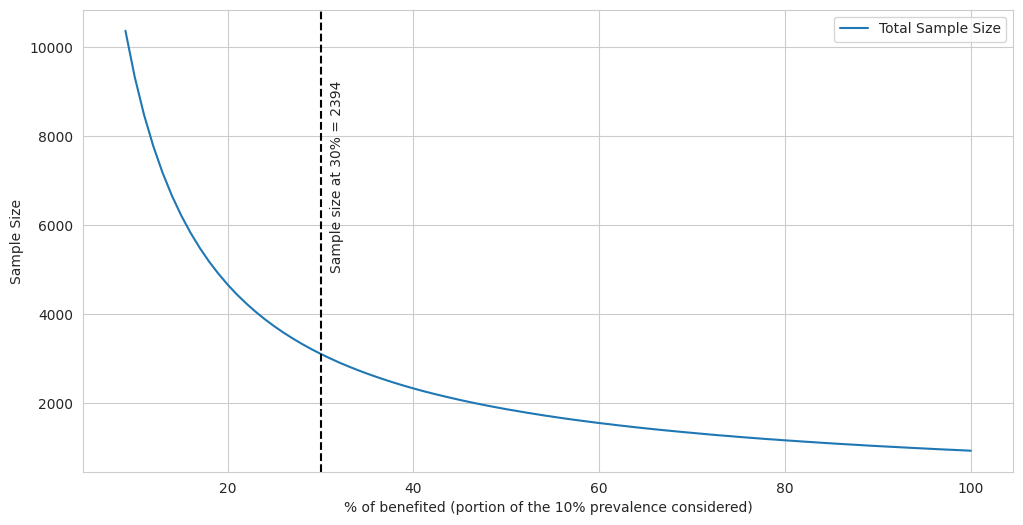

In [11]:
# Plot the results
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(range(9,101), sample_sizes, label="Total Sample Size")
plt.xlabel("% of benefited (portion of the 10% prevalence considered)")
plt.ylabel("Sample Size")

# At 30 add a vertical line and a label indicating y value
plt.axvline(30, color='k', linestyle='--')
plt.text(31, 5000, f'Sample size at 30% = {sample_sizes[30]}', rotation=90)

plt.legend()
plt.show()

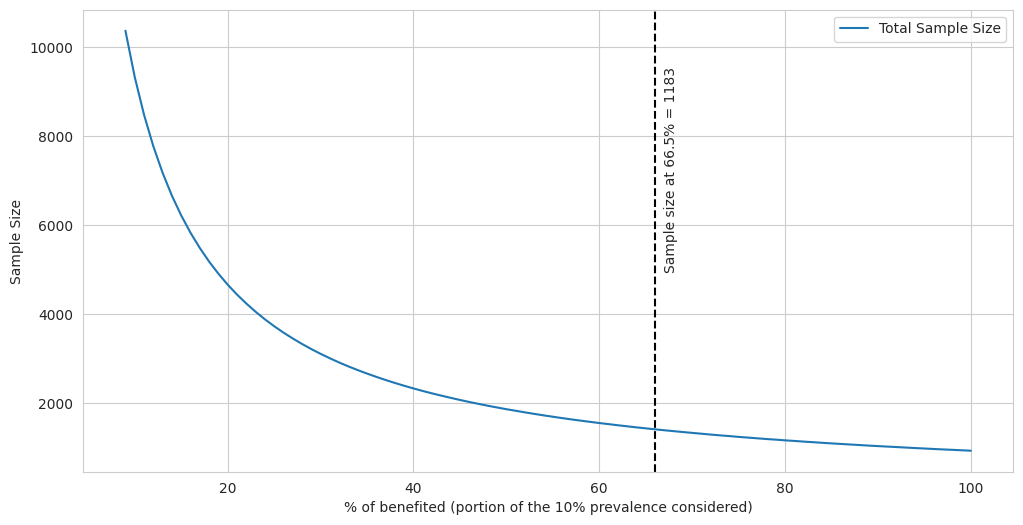

In [12]:
# Plot the results
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(range(9,101), sample_sizes, label="Total Sample Size")
plt.xlabel("% of benefited (portion of the 10% prevalence considered)")
plt.ylabel("Sample Size")

# At 30 add a vertical line and a label indicating y value
plt.axvline(66, color='k', linestyle='--')
plt.text(67, 5000, f'Sample size at 66.5% = {sample_sizes[70]}', rotation=90)

plt.legend()
plt.show()

# Statistical power for specificity

If we take into consideration only the primary outcome of the test that we're doing (sensitivity), then we can claim certain statistical power over other metrics like specificity. Let's compute it.

In [13]:
import statsmodels.api as sm

def compute_statistical_power(sample_size, specificity, baseline_specificity=0.5, significance_level=0.05):
    # Calculate the effect size based on proportions
    effect_size = sm.stats.proportion_effectsize(specificity, baseline_specificity)
    
    # Compute the power of the test
    power = sm.stats.NormalIndPower().power(
        effect_size=effect_size,
        nobs1=sample_size,
        alpha=significance_level,
        alternative='larger'
    )
    
    return power

In [15]:
# Fixed params
sample_size = 840
specificity = 0.87
significance_level = 0.05


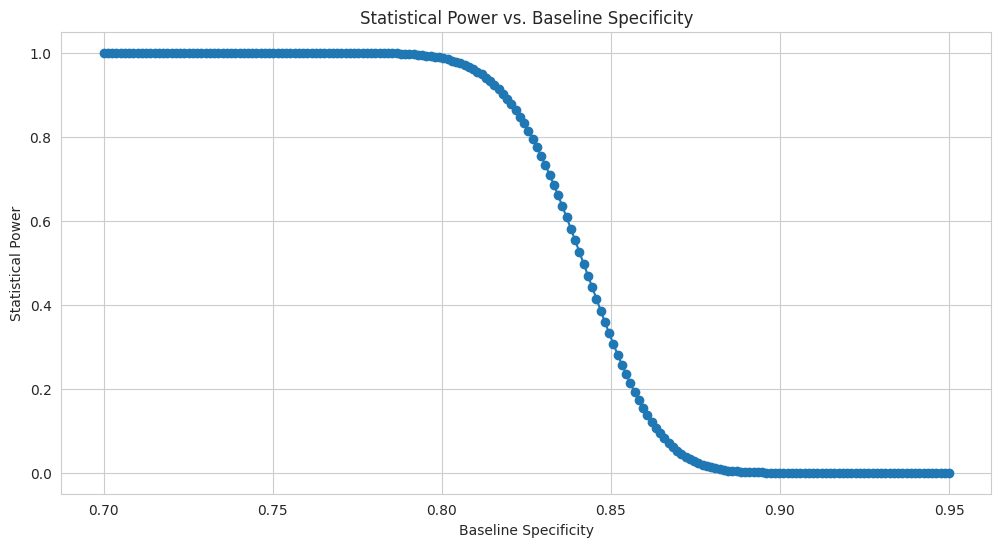

In [16]:
import numpy as np

powers = {}
for baseline_specificity in np.linspace(0.7, 0.95, 200):
    powers[baseline_specificity] = compute_statistical_power(sample_size, specificity, baseline_specificity, significance_level)
    
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
plt.plot(list(powers.keys()), list(powers.values()), marker='o')
plt.xlabel("Baseline Specificity")
plt.ylabel("Statistical Power")
plt.title("Statistical Power vs. Baseline Specificity")
plt.show()

Given that the pipelle has a specificity of 100% (no false positives), we should decide which is the baseline ("no-effect") we want to compare to in order to compute statistical power. 